**Forward-Projection and (Filtered-) Back-Projection**

*from Kai Benning
(kai.benning@uni-wuppertal.de || kai.benning@gmx.de)
| Projection Notebook v1.0
| 4.Juni.2019*

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

Read in the Grayscale-TIFF-Image and then pad the 512x512 Image with 107 Zeros on every side so we can rotate the image without the need of reshaping.

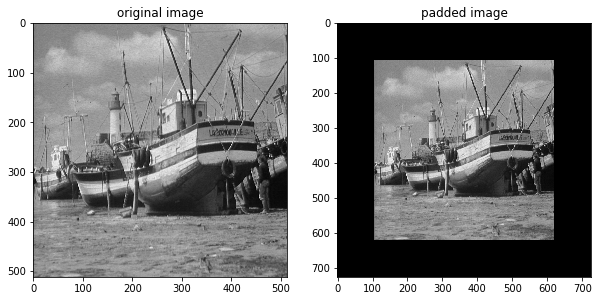

In [2]:
boat_image = plt.imread("image/boat.tiff")
boat_image_padded = np.pad(boat_image, [(107, 107), (107, 107)], mode='constant')

plt.figure(figsize = (10,6))
plt.subplot(121)
plt.title("original image")
plt.imshow(boat_image,cmap = "gray")

plt.subplot(122)
plt.title("padded image")
plt.imshow(boat_image_padded,cmap = "gray")

plt.show()

And lets rotate the Image around 45, 60, and 90 degrees. (Just for fun!)

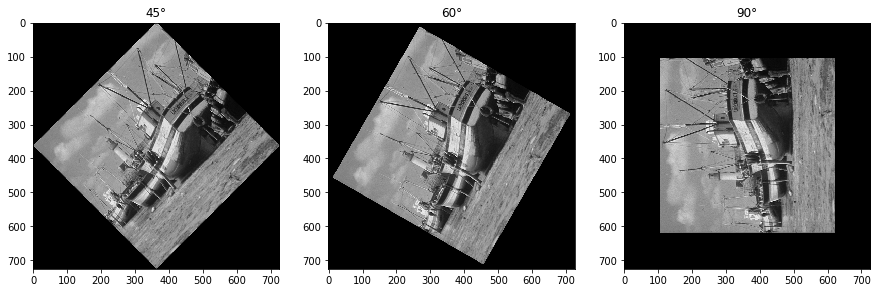

In [3]:
rotated_boat_45 = ndimage.rotate(boat_image_padded, 45, reshape=False)
rotated_boat_60 = ndimage.rotate(boat_image_padded, 60, reshape=False)
rotated_boat_90 = ndimage.rotate(boat_image_padded, 90, reshape=False)

plt.figure(figsize=(15,8))

plt.subplot(131)
plt.title("45°")
plt.imshow(rotated_boat_45,cmap = "gray")

plt.subplot(132)
plt.title("60°")
plt.imshow(rotated_boat_60,cmap = "gray")

plt.subplot(133)
plt.title("90°")
plt.imshow(rotated_boat_90,cmap = "gray")

plt.show()

So that's works! We will now create a set of projections called a sinogram. Therefore we create an empty array which has 180 Columns (for the same amount of rotation angles) and 726 Rows (for the 726 Projections along the image-columns) and fill it with our projections. We calculate the projections by rotating the image and summing along the second dimension (Index 1).

In [4]:
angle_array = np.array(range(0,180,1))
projection_dim = boat_image_padded.shape[0]
angle_dim = angle_array.shape[0]

column_axis = 1
sinogram = np.zeros((angle_dim,projection_dim))

for i,j in enumerate(angle_array):
    tmp_im = ndimage.rotate(boat_image_padded, j, reshape=False)
    sinogram[i,:] = np.sum(tmp_im,axis = column_axis)
    

And now let's display the sinogram:

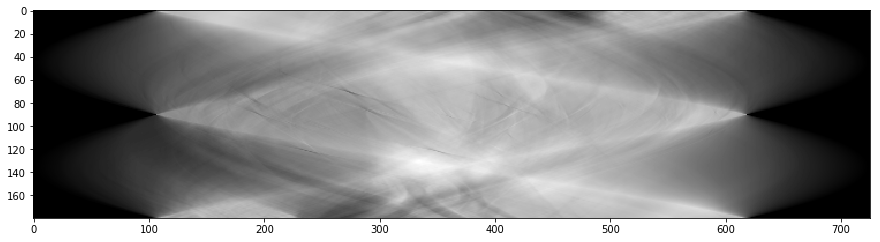

In [5]:
plt.figure(figsize = (15,15))
plt.imshow(sinogram,cmap="gray")
plt.show()

Now we want to reconstruct the original Image from the projections. Because that's our problem if we get the data of a CT-Scan. We define two empty 2D array: one for the final reconstructed image "reco_image" and one for the temporary slice "proj_tmp".

In [6]:
reco_image = np.zeros((projection_dim,projection_dim))
proj_tmp = np.zeros((projection_dim,projection_dim))

Loop trough all elements of the Sinogram, rotate, and add them up.

In [7]:
for i,j in enumerate(sinogram):
    proj_tmp[:,:] = j
    reco_image += ndimage.rotate(proj_tmp, i, reshape=False)

And plot the Image.

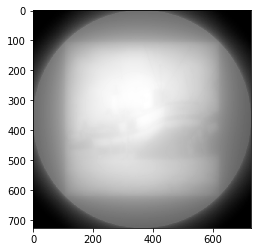

In [8]:
plt.figure()
plt.imshow(reco_image.T,cmap = "gray")
plt.show()

The image is really blurry! We will use high-pass-filtering in the fourier-space to get rid of the low frequencies.

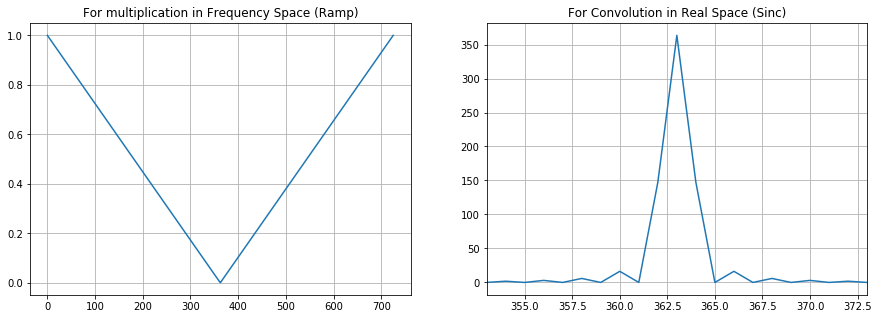

In [9]:
import numpy.fft as fft

ramp_filter = np.linspace(-1,1,projection_dim)
ramp_filter = np.abs(ramp_filter)

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title("For multiplication in Frequency Space (Ramp)")
plt.plot(ramp_filter)
plt.grid()

plt.subplot(122)
plt.title("For Convolution in Real Space (Sinc)")
tmp = fft.fft(ramp_filter)
tmp = fft.fftshift(tmp)
plt.plot(np.abs(tmp))
plt.xlim([projection_dim/2-10,projection_dim/2+10])

plt.grid()
plt.show()


In [10]:
sinogram_filtered = np.zeros(sinogram.shape)
for i,j in enumerate(sinogram):
    
    tmp = np.fft.fftshift(np.fft.fft(j))*ramp_filter
    tmp2 = np.fft.ifft(np.fft.ifftshift(tmp))
    
    sinogram_filtered[i] = tmp2.real

We filter the sinogram, and plot the filtered sinogram with another colormaps to enhance the visibility of the edges.

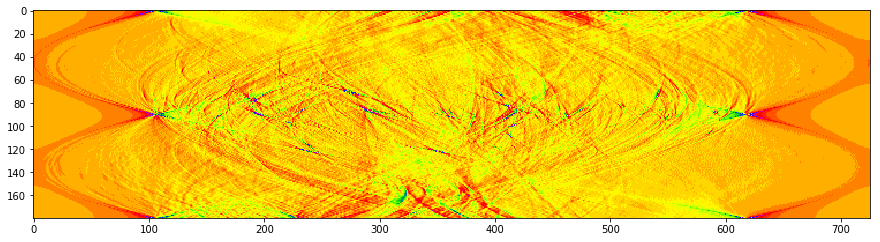

In [11]:
plt.figure(figsize = (15,15))
plt.imshow(sinogram_filtered,cmap="prism")
plt.show()

Running the same backprojection-algorithm with the filtered Sinogram is now called a *filtered-Backprojection (FBP)*

In [14]:
reco_image_filtered = np.zeros(reco_image.shape)
for i,j in enumerate(sinogram_filtered):
    proj_tmp[:,:] = j
    reco_image_filtered += ndimage.rotate(proj_tmp, i, reshape=False)

And now we expect the results to be much *clearer*:

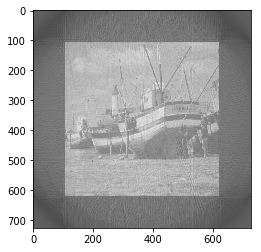

In [15]:
plt.figure()
plt.imshow(reco_image_filtered.T,cmap = "gray")
plt.show()

Tada!